In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import cairo
import numpy as np
import PIL
import ot
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

In [2]:
class Synthetic:
    def __init__(self, MAX_X=28, MAX_Y=28, border=4):
        self.MAX_X = MAX_X
        self.MAX_Y = MAX_Y
        self.border = border

    def random_line(self, ctx):
        x = []
        y = []
        for it in range(2):
            x.append(np.random.randint(self.border, self.MAX_X - self.border))
            y.append(np.random.randint(self.border, self.MAX_Y - self.border))
            
        return self.line(ctx, x, y)
        
    def line(self, ctx, x, y):
        ctx.move_to(x[0], y[0])
        ctx.line_to(x[1], y[1])

        ctx.set_line_join(cairo.LINE_JOIN_MITER)
        ctx.set_line_cap(cairo.LINE_CAP_BUTT)

        ctx.stroke()
        ctx.close_path()
        if (x[0], y[0]) < (x[1], y[1]):
            return x[0], y[0], x[1], y[1]
        else:
            return x[1], y[1], x[0], y[0]

    def get_image(self, img_path='../data/Synthetic/', name='1', line_count=2):
        ps = cairo.SVGSurface(img_path + name + "svgfile1.svg", self.MAX_X, self.MAX_Y)
        ctx = cairo.Context(ps)
        ctx.save()
        ctx.set_source_rgb(0, 0, 0)
        ctx.paint()
        ctx.restore()
        ctx.move_to(0, 0)
        mass = []
        for it in range(line_count):
            width = np.random.randint(1, 6)
            ctx.set_line_width(width)
            ctx.set_source_rgba(1, 1, 1, 1)
            mass.append(self.random_line(ctx) + (width,))
        mass.sort()
        ctx.set_operator(cairo.OPERATOR_MULTIPLY)
        ps.write_to_png(img_path + name + '_nh_gt.png')
        image = Image.open(img_path + name + '_nh_gt.png')
        inverted_image = PIL.ImageOps.invert(image)
        inverted_image = inverted_image.convert('L')
        inverted_image.save(img_path + name + '_nh_gt.png')

        return inverted_image, mass

    def r_line(self, ctx, ln):
        ctx.new_sub_path()
        ctx.save()
        ctx.move_to(ln[0], ln[1])
        ctx.line_to(ln[2], ln[3])

        ctx.set_line_join(cairo.LINE_JOIN_MITER)
        ctx.set_line_cap(cairo.LINE_CAP_SQUARE)

        ctx.stroke()
        ctx.close_path()
        ctx.restore()

    def render(self, lines, img_path='../data/Synthetic/', name='1'):
        ps = cairo.SVGSurface(img_path + name + "svgfile1.svg", self.MAX_X, self.MAX_Y)
        ctx = cairo.Context(ps)
        ctx.save()
        ctx.set_source_rgb(0, 0, 0)
        ctx.paint()
        ctx.restore()
        ctx.move_to(0, 0)

        for ln in lines:
            if ln[-1] < 0.5:
                continue
            width = ln[4]
            ctx.set_line_width(width)
            ctx.set_source_rgba(1, 1, 1, 1)

            self.r_line(ctx, ln)

        ctx.set_operator(cairo.OPERATOR_MULTIPLY)
        ps.write_to_png(img_path + name + '_nh_gt.png')
        image = Image.open(img_path + name + '_nh_gt.png')
        inverted_image = PIL.ImageOps.invert(image)
        inverted_image = inverted_image.convert('L')
        inverted_image.save(img_path + name + '_nh_gt.png')

        return inverted_image

In [3]:
def line_to_coords_and_mass(line):
    """
    Returns (x_center, y_center, normal_slope, mass)
    """
    x0, y0, x1, y1, width = line
    mass = np.sum(1 - np.array(Synthetic(64, 64).render([line], '.')) / 255)
    x_center, y_center = (x1 + x0) / 2, (y1 + y0) / 2
    
    if y1 == y0:
        angle = 0.0
    else:
        angle = np.arctan((y1 - y0) / float(x1 - x0))
        if angle < 0:
            angle = np.pi + angle
    
    return (x_center, y_center), mass
    

In [4]:
def spread_out_coords_and_mass(line, n_points=4):
    x0, y0, x1, y1, width = line
    (x_center, y_center), mass = line_to_coords_and_mass(line)
    
    x_linspace = np.linspace(x0, x1, n_points)
    y_linspace = np.linspace(y0, y1, n_points)
    
    return np.vstack((x_linspace, y_linspace)).T, np.full((n_points, ), mass / n_points)

In [7]:
def spread_masses(plines, n_points_per_line=8):

    line_coords = np.zeros((n_points_per_line * len(plines), 2))
    line_masses = np.zeros((n_points_per_line * len(plines,)))

    for i, line in enumerate(plines):
        coords, masses = spread_out_coords_and_mass(line, n_points_per_line)

        line_coords[i * n_points_per_line : (i + 1) * n_points_per_line] = coords
        line_masses[i * n_points_per_line : (i + 1) * n_points_per_line] = masses
        
    return line_coords, line_masses

In [8]:
def render_pimage_from_plines(synthetic, plines):
    pimage = 1 - np.array(synthetic.render(plines, '.')) / 255
    return pimage

In [9]:
def shift_lines(lines, dx=0, dy=0):
    new_masses = []
    
    for mass in lines:
        mass = list(mass)
        
        mass[0] += dx
        mass[2] += dx
        
        mass[1] += dy
        mass[3] += dy
        
        new_masses.append(tuple(mass))
            
    return new_masses

In [10]:
def compute_pixel_coords(image):
    return np.argwhere(image)


def compute_pixel_density(image):
    pixel_density = image[np.nonzero(image)]
    pixel_density /= np.sum(pixel_density)
    return pixel_density

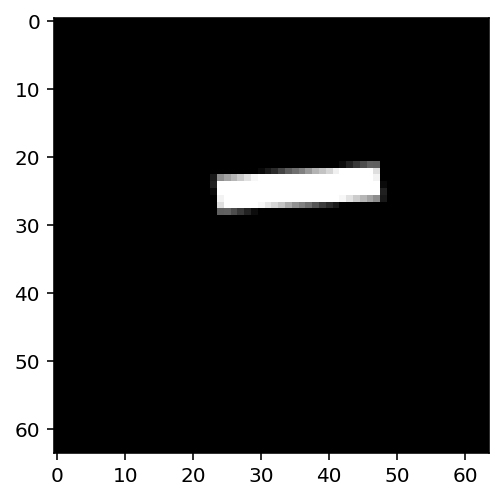

In [11]:
s = Synthetic(64, 64)

np.random.seed(111)

image, lines = s.get_image('.', line_count=1)
image = 1 - np.array(image) / 255
plt.imshow(image, cmap='gist_gray')
plt.show()

14.995340296677908
14.491379581989307
14.073211890449285


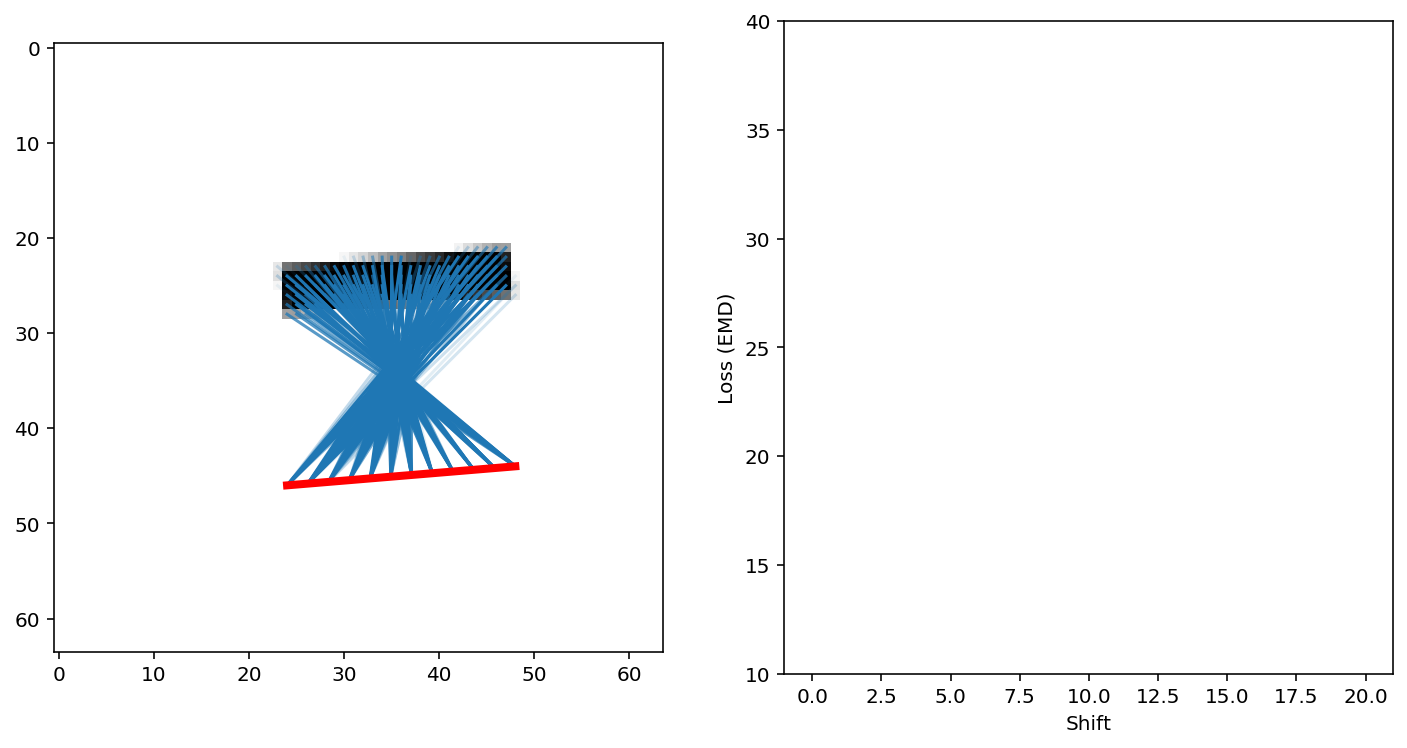

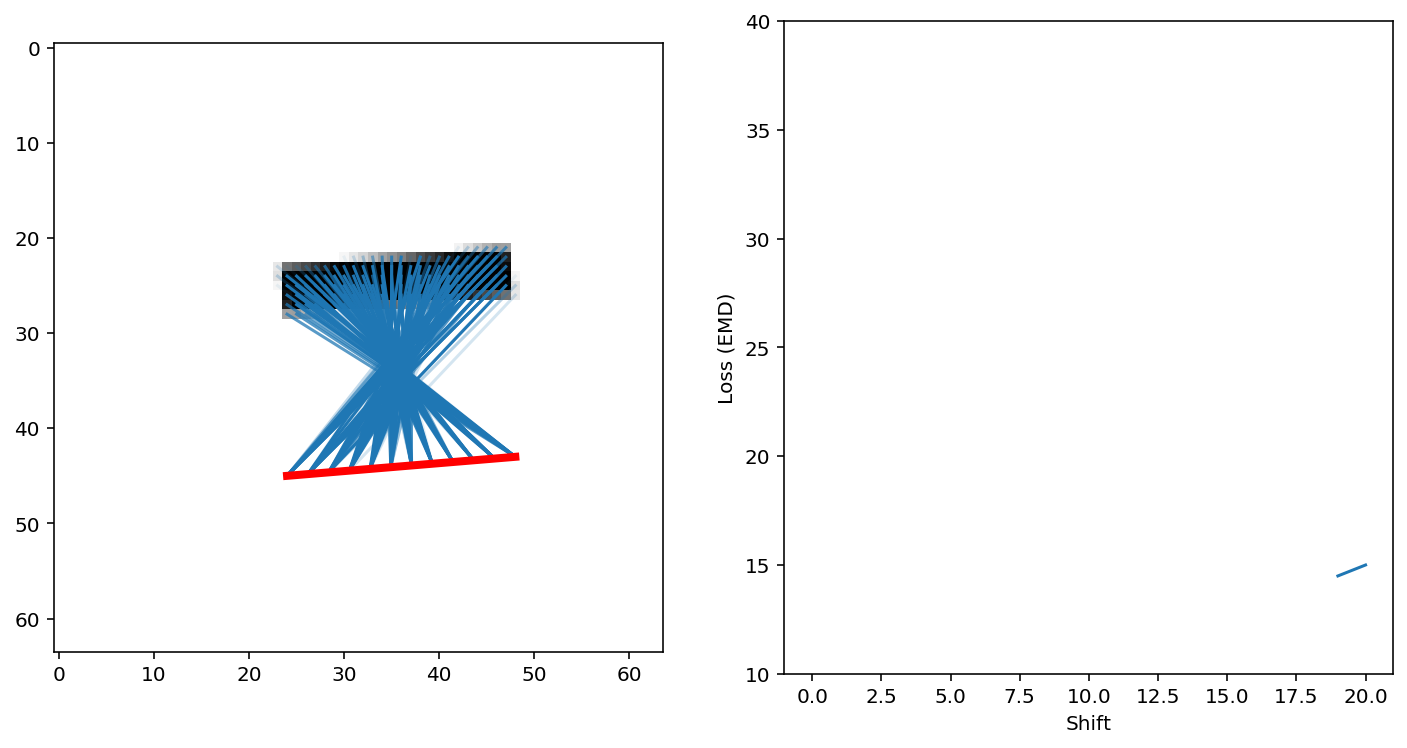

KeyboardInterrupt: 

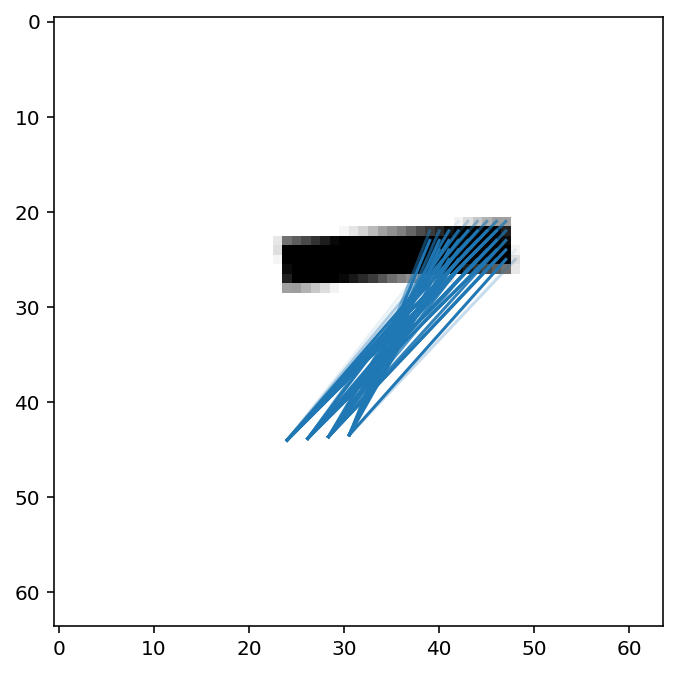

In [12]:
lambd = 0.001
n_points_per_line = 12

losses = []

for step, x_shift in enumerate(range(20, -1, -1)):
    
    plines = shift_lines(lines, 0, x_shift)
    
    line_coords, line_masses = spread_masses(plines, n_points_per_line=n_points_per_line)
    line_masses /= np.sum(line_masses)
    
    pixel_coords = compute_pixel_coords(image)
    pixel_density = compute_pixel_density(image)
    
    distance_matrix = ot.dist(line_coords, pixel_coords, 'euclidean')
    transport_matrix = ot.emd(line_masses, pixel_density, distance_matrix)
    loss = ot.emd2(line_masses, pixel_density, distance_matrix)
    print(loss)
    losses.append(loss)
    
    plt.figure(figsize=(12, 6))
    plt.title(f'Loss: {loss}')
    
    plt.subplot(121)
    plt.imshow(image, cmap='gray_r')

    for i in range(transport_matrix.shape[0]):
        for j in range(transport_matrix.shape[1]):
            plt.plot([line_coords[i][0], pixel_coords[j][1]], [line_coords[i][1], pixel_coords[j][0]], 
                     alpha=20 * transport_matrix[i, j] / transport_matrix[i].sum(),
                     color=f'C{i // n_points_per_line}')

    for x0, y0, x1, y1, width in plines:
        plt.plot([x0, x1], [y0, y1], linewidth=4, color='red')
        
    plt.subplot(122, ylabel='Loss (EMD)', xlabel='Shift', autoscaley_on=True)
    plt.xlim(-1, 21)
    plt.ylim(10, 40)
    plt.plot(np.arange(20, 20 - step - 1, -1), losses)
    
#     plt.savefig(f'ot_emd_{step}.png', dpi=300)

    plt.show()

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from geomloss import SamplesLoss

use_cuda = torch.cuda.is_available()
dtype    = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor


In [23]:
torch_line_coords = torch.from_numpy(np.vstack((line_coords[:, 1], line_coords[:, 0])).T.astype(np.float32))
torch_pixel_coords = torch.from_numpy(pixel_coords.astype(np.float32))

torch_line_masses = torch.from_numpy(line_masses.astype(np.float32))
torch_pixel_density = torch.from_numpy(pixel_density.astype(np.float32))

loss = SamplesLoss("sinkhorn", p=2, blur=.01)
loss(torch_line_masses, torch_line_coords, torch_pixel_density, torch_pixel_coords)

tensor(172.3692)

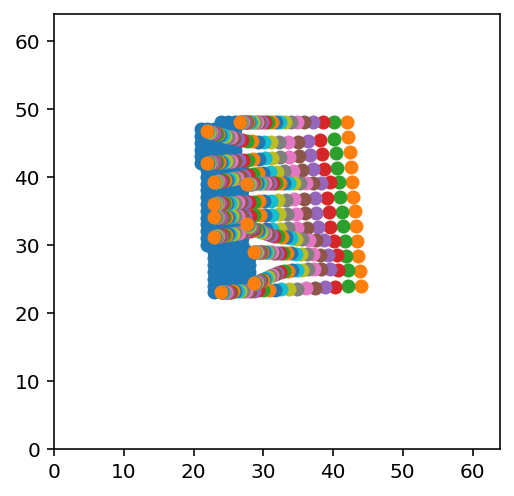

In [24]:
x_i = torch_line_coords.clone()
y_j = torch_pixel_coords.clone()

a_i = torch_line_masses.clone()
b_j = torch_pixel_density.clone()

x_i.requires_grad = True
# a_i.requires_grad = True

lr = 0.1

plt.figure(figsize=(4, 4))
plt.xlim(0, 64)
plt.ylim(0, 64)
plt.scatter(y_j[:, 0], y_j[:, 1])
plt.scatter(x_i.detach().cpu().numpy()[:, 0], x_i.detach().cpu().numpy()[:, 1])

for i in range(30):
    
    if x_i.grad is not None:
        x_i.grad.data.zero_()

    sample_loss = loss(a_i, x_i, b_j, y_j)
    sample_loss.backward()
    
    g_x = x_i.grad.data

    x_i.data -= lr * len(x_i) * g_x
    
    plt.scatter(x_i.detach().cpu().numpy()[:, 0], x_i.detach().cpu().numpy()[:, 1])

plt.savefig('OT.png', dpi=300)

In [25]:
loss_result = loss(a_i, x_i, b_j, y_j)
loss_result.backward()



In [26]:
from differentiable_rendering.sigmoids_renderer.renderer import Renderer

renderer = Renderer((64, 64), linecaps='butt', dtype=torch.float32)

In [27]:
plines

[(24, 44, 48, 42, 5)]

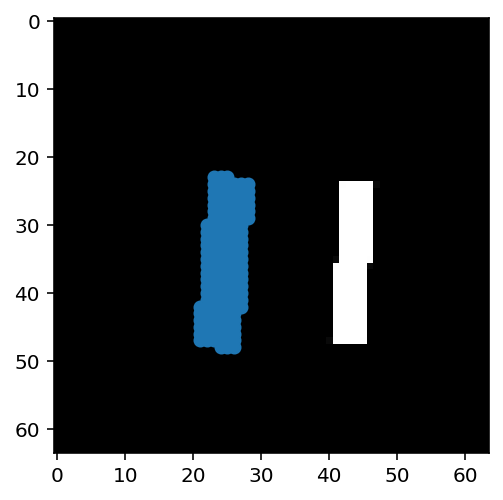

In [28]:
line_batch = np.array([[[45., 24., 43., 48., 5., 0.5]]]).astype(np.float32)
line_batch = torch.from_numpy(line_batch)
line_batch.requires_grad = True

plt.imshow(renderer.render(line_batch)[0].detach().cpu().numpy(), cmap='gist_gray')
plt.scatter(y_j[:, 0], y_j[:, 1])

In [29]:
plane = renderer.render(line_batch)[0]

In [30]:
torch.nonzero(plane)

tensor([[23, 42],
        [23, 43],
        [23, 44],
        [23, 45],
        [23, 46],
        [23, 47],
        [24, 42],
        [24, 43],
        [24, 44],
        [24, 45],
        [24, 46],
        [24, 47],
        [25, 41],
        [25, 42],
        [25, 43],
        [25, 44],
        [25, 45],
        [25, 46],
        [25, 47],
        [26, 41],
        [26, 42],
        [26, 43],
        [26, 44],
        [26, 45],
        [26, 46],
        [26, 47],
        [27, 41],
        [27, 42],
        [27, 43],
        [27, 44],
        [27, 45],
        [27, 46],
        [27, 47],
        [28, 41],
        [28, 42],
        [28, 43],
        [28, 44],
        [28, 45],
        [28, 46],
        [28, 47],
        [29, 41],
        [29, 42],
        [29, 43],
        [29, 44],
        [29, 45],
        [29, 46],
        [29, 47],
        [30, 41],
        [30, 42],
        [30, 43],
        [30, 44],
        [30, 45],
        [30, 46],
        [30, 47],
        [31, 41],
        [3

In [31]:
loss(plane, torch_pixel_coords)

ValueError: Input samples 'x' and 'y' should have the same last dimension.

In [ ]:
plane[plane > 1e-6]

In [32]:
torch.meshgrid([torch.linspace(-1, 1, 64), torch.linspace(-1, 1, 64)])

(tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-0.9683, -0.9683, -0.9683,  ..., -0.9683, -0.9683, -0.9683],
         [-0.9365, -0.9365, -0.9365,  ..., -0.9365, -0.9365, -0.9365],
         ...,
         [ 0.9365,  0.9365,  0.9365,  ...,  0.9365,  0.9365,  0.9365],
         [ 0.9683,  0.9683,  0.9683,  ...,  0.9683,  0.9683,  0.9683],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]]),
 tensor([[-1.0000, -0.9683, -0.9365,  ...,  0.9365,  0.9683,  1.0000],
         [-1.0000, -0.9683, -0.9365,  ...,  0.9365,  0.9683,  1.0000],
         [-1.0000, -0.9683, -0.9365,  ...,  0.9365,  0.9683,  1.0000],
         ...,
         [-1.0000, -0.9683, -0.9365,  ...,  0.9365,  0.9683,  1.0000],
         [-1.0000, -0.9683, -0.9365,  ...,  0.9365,  0.9683,  1.0000],
         [-1.0000, -0.9683, -0.9365,  ...,  0.9365,  0.9683,  1.0000]]))

In [33]:
spatial = renderer.render(line_batch).unsqueeze(1)


In [34]:
plane

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<SelectBackward>)

In [35]:
(plane / plane.sum()).flatten()

tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<AsStridedBackward>)

In [36]:
coords = torch.from_numpy(np.mgrid[0:64, 0:64].reshape(2, -1).T.astype(np.float32))

In [37]:
coords

tensor([[ 0.,  0.],
        [ 0.,  1.],
        [ 0.,  2.],
        ...,
        [63., 61.],
        [63., 62.],
        [63., 63.]])

In [46]:
loss((plane / plane.sum()).flatten(), coords, b_j, y_j)

tensor(121.8792, grad_fn=<SelectBackward>)

In [ ]:
line_batch = np.array([[[45., 24., 43., 48., 5., 0.5]]]).astype(np.float32)
line_batch = torch.from_numpy(line_batch)
line_batch.requires_grad = True

x_i = coords.clone()
y_j = torch_pixel_coords.clone()

# a_i = torch_line_masses.clone()
b_j = torch_pixel_density.clone()

# x_i.requires_grad = True
# a_i.requires_grad = True

lr = 0.01

# plt.figure(figsize=(4, 4))
# plt.xlim(0, 64)
# plt.ylim(0, 64)
# plt.scatter(y_j[:, 0], y_j[:, 1])
# plt.scatter(x_i.detach().cpu().numpy()[:, 0], x_i.detach().cpu().numpy()[:, 1])

for i in range(200):
    
    print(i)
    
    plane = renderer.render(line_batch)[0]
    plane = (plane / plane.sum()).flatten()
    
    if line_batch.grad is not None:
        line_batch.grad.data.zero_()

    sample_loss = loss(plane, x_i, b_j, y_j)
    sample_loss.backward()
    
    g_line_batch = line_batch.grad.data

    line_batch.data -= lr * g_line_batch
    
    
    
    # plt.scatter(x_i.detach().cpu().numpy()[:, 0], x_i.detach().cpu().numpy()[:, 1])

0
1


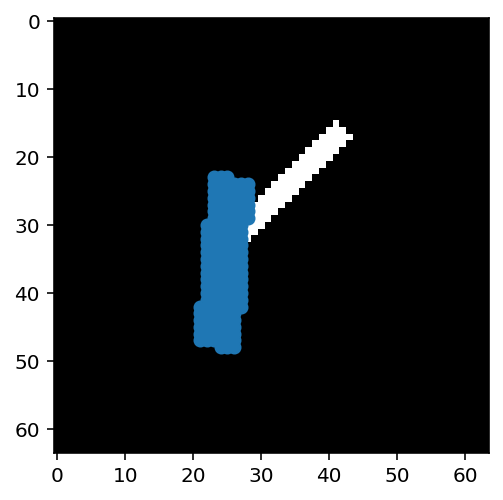

In [39]:
plt.imshow(renderer.render(line_batch)[0].detach().cpu().numpy(), cmap='gist_gray')
plt.scatter(y_j[:, 0], y_j[:, 1])


In [ ]:
line_batch
